# Tutorial 3.3: Attribution analysis

In [1]:
import os, warnings, torch

import torch.nn as nn
import scanpy as sc
import pandas as pd

from model.nicheTrans_attribution_SMA import *
from datasets.data_manager_SMA import SMA

from utils.utils import *
from utils.utils_dataloader import *
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from collections import defaultdict

from palettable.cartocolors.diverging import *
from palettable.scientific.diverging import *

### Load dataset

In [ ]:
# please load the target Visium data (from the uploaded)
adata_path = '/home/wzk/ST_code/NicheTrans/2024_NicheTrans_upload_data/2023_nbt_SMA/Processed_data_used/V11L12-109_A1'
rna_adata = sc.read_visium(path=adata_path, count_file='filtered_feature_bc_matrix.h5')

In [3]:
coordiantes = []
for i in range(rna_adata.shape[0]):
    coordiantes.append(str(rna_adata.obs['array_row'].values[i]) + '_' + str(rna_adata.obs['array_col'].values[i]) )
coordiantes = np.array(coordiantes)

rna_adata.obs['coordinates'] = coordiantes

### Load args

In [4]:
%run ./args/args_SMA.py
args = args

### Create dataloader

In [5]:
# create the dataloaders
dataset = SMA(path_img=args.path_img, rna_path=args.rna_path, msi_path=args.msi_path, n_top_genes=args.n_source, n_top_targets=args.n_target)
_, testloader = sma_dataloader(args, dataset)

------Calculating spatial graph...
The graph contains 12134 edges, 3120 cells.
3.8891 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 24190 edges, 3120 cells.
7.7532 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 11322 edges, 2918 cells.
3.8801 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 22578 edges, 2918 cells.
7.7375 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 10360 edges, 2675 cells.
3.8729 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 20628 edges, 2675 cells.
7.7114 neighbors per cell on average.
=> SMA loaded
Dataset statistics:
  ------------------------------
  subset   | # num | 
  ------------------------------
  train    |  Without filtering  6038 spots from     2 slides 
  test     |  Without filtering  2675 spots from     1 slides
  train    |  After filting  6005 spots from     2 

### Model initialization

In [ ]:
# create the model
source_dimension, target_dimension = dataset.rna_length, dataset.msi_length
model = NicheTrans(source_length=source_dimension, target_length=target_dimension, noise_rate=args.noise_rate, dropout_rate=args.dropout_rate)
model = nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('NicheTrans_SMA_last.pth'))
model.eval() 

DataParallel(
  (module): NicheTrans(
    (encoder): NetBlock(
      (noise_dropout): Dropout(p=0.2, inplace=False)
      (linear_list): ModuleList(
        (0): Linear(in_features=1159, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=256, bias=True)
      )
      (bn_list): ModuleList(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_list): ModuleList(
        (0-1): 2 x LeakyReLU(negative_slope=0.01)
      )
      (dropout_list): ModuleList(
        (0): Dropout(p=0.1, inplace=False)
      )
    )
    (fusion_omic): Self_Attention(
      (to_q): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=False)
      )
      (to_k): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=False)
      )
      (to_v): Linear(in_features=256, out_features=256, bias=F

### Model inference 

In [ ]:
input_list = []

with torch.no_grad():
    for _, (imgs, source, target, source_neightbors, _, samples) in enumerate(testloader):

        source, target, source_neightbors = source.cuda(), target.cuda(), source_neightbors.cuda()
        
        source_data = torch.cat([source[:, None, :], source_neightbors], dim=1)
        input_list.append(source_data)

rna_list = torch.cat(input_list, dim=0)

In [9]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)

baseline = torch.zeros_like(rna_list).cuda()
attributions = ig.attribute(rna_list, baseline, target=0)  # Adjust target if your model has multiple outputs

attributions = attributions.detach().cpu().numpy()

In [10]:
num_genes = 30
attributions = np.abs(attributions)
grad_norm = attributions.sum(axis=0).sum(axis=0)

top_indices = np.argsort(grad_norm)[-num_genes:]
temp_mask = grad_norm >= grad_norm[top_indices[0]]

highly_correlated_genes_0 = dataset.source_panel[top_indices]

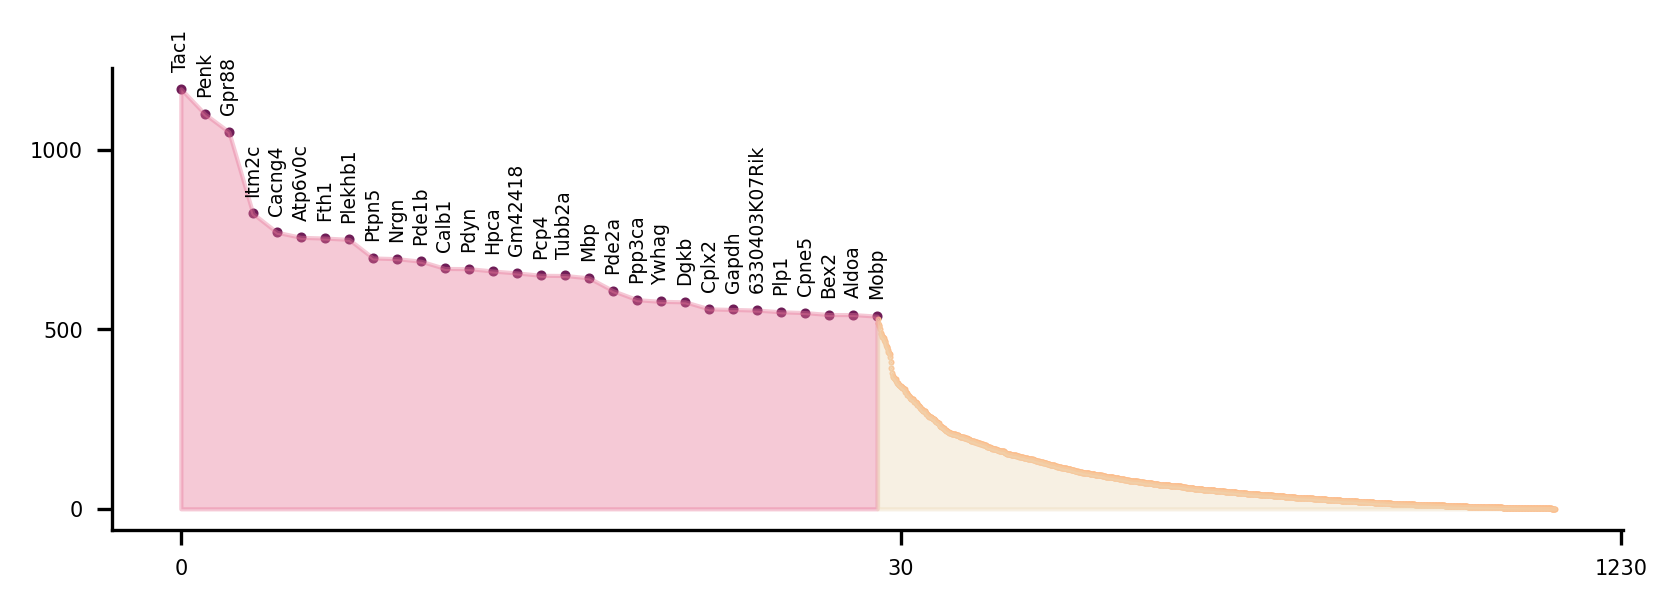

In [11]:
sorted_data = np.sort(grad_norm.squeeze())[::-1]
indices = np.arange(len(sorted_data))

fig, ax = plt.subplots(1, figsize=(6.5, 2), dpi=300)

plt.scatter(indices[0:30], sorted_data[0:30], s=2, color='#6F1D57')
plt.scatter(29 + (indices[30:] -29)/40, sorted_data[30:], s=0.2, color='#FCBD8B')

num_genes
for i in range(num_genes):
    plt.annotate(highly_correlated_genes_0[num_genes-i -1],
                 xy=(i, sorted_data[i]),
                 xytext=(0, 5),  
                 textcoords='offset points',
                 ha='center',  
                 rotation=90,
                 fontsize=4.5)  

                 
plt.fill_between(indices[0:30], sorted_data[0:30], color='#E8789A', alpha=0.4)
plt.fill_between(29 + (indices[30:]- 29 )/40, sorted_data[30:], color='#EDDAB9', alpha=0.4)

custom_xticks = [0, 30, 60]
custom_xticklabels = ['0', '30', '1230']

ax.set_xticks(custom_xticks)
ax.set_xticklabels(custom_xticklabels, fontsize=5)
plt.yticks(fontsize=5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()